# Outlier Detection With Autoencoders

based on: https://towardsdatascience.com/outlier-detection-with-autoencoders-6c7ac3e2aa90

<b> environment

In [2]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<b> Define data

In [ ]:
def trend(time, slope=0):
    """A trend over time"""
    return slope * time

def seasonal_pattern(season_time):
    """Arbitrary pattern"""
    return np.where(season_time < 0.1,np.cos(season_time * 7 * np.pi),1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    """Adds noise to the series"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


TIME = np.arange(4 * 365 + 1, dtype="float32")

y_intercept = 10
slope = 0.01
SERIES = trend(TIME, slope) + y_intercept

amplitude = 40
SERIES += seasonality(TIME, period=365, amplitude=amplitude)

noise_level = 2
SERIES += noise(TIME, noise_level, seed=42)

plt.plot(TIME, SERIES)

<b> Define outliers

In [7]:
SERIES[500] = 100
SERIES[1000] = -100

<b> Plot data

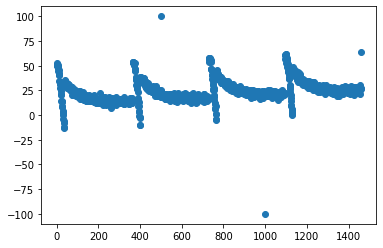

In [11]:
plt.scatter(TIME, SERIES)

In [14]:
def train_val_split(time, series, time_step):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]
    return time_train, series_train, time_valid, series_valid
# Split the dataset

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ### START CODE HERE
    # Create dataset from the series
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Slice the dataset into the appropriate windows
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    # Flatten the dataset
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    # Shuffle it
    dataset = dataset.shuffle(shuffle_buffer)
    # Split it into the features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    # Batch it
    dataset = dataset.batch(batch_size).prefetch(1)
    ### END CODE HERE
    return dataset

SPLIT_TIME = 1100
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES, SPLIT_TIME)
test_dataset = windowed_dataset(series_train, window_size=1, batch_size=5, shuffle_buffer=1)

batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (5, 1)

batch_of_labels has shape: (5,)

